In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
data_path = '../data/CALC_STRAIGHT/'
files = [f for f in os.listdir(data_path) if f.endswith('.csv')]

In [3]:
print('STRAIGHT SEGMENTS:\t'+ str(len(files)))

STRAIGHT SEGMENTS:	232


In [4]:
A = pd.read_csv('../data/STRAIGHT_STEP_FREQ.csv')
A.head()

,File,IndexStart,IndexEnd,StepsL,StepsR,Ts,SegLen,TimeLen,StepFreqL,StepFreqR,Type
0,N-15-1-Char00part2seg-0.csv,24774.0,25295.0,7.0,7.0,0.017,522.0,8.874,0.788821,0.788821,N
1,N-15-1-Char00part3seg-0.csv,25433.0,26395.0,12.0,13.0,0.017,963.0,16.371,0.733003,0.794087,N
2,N-04-1-Char00part7seg-3.csv,57701.0,59747.0,13.0,14.0,0.008,2047.0,16.376,0.793845,0.854910,N
3,A-736123-Char00part1seg-0.csv,2900.0,4287.0,18.0,18.0,0.017,1388.0,23.596,0.762841,0.762841,A
4,N-15051994-Char00part2seg-0.csv,18500.0,20250.0,13.0,13.0,0.008,1751.0,14.008,0.928041,0.928041,N


In [5]:
text_file = open('../data/JointNamesCalc.txt', "r")
joint_names_calc = text_file.read().split('\n')
len(joint_names_calc)

61

In [6]:
spine_joints = ['Spine3','Spine2','Spine1','Spine','Hips']
spine_joints_ind = np.zeros([len(spine_joints),1])
cc = 0
for c in spine_joints:
    spine_joints_ind[cc] = joint_names_calc.index(c) + 1
    cc+=1
spine_joints_ind

array([[18.],
       [19.],
       [20.],
       [21.],
       [ 1.]])

In [7]:
def euclidean(df):
    N = np.size(df,axis=0)
    dist = np.zeros((N-1))
    for n in range(1,N):
        dist[n-1] = ((df.iloc[n,0]-df.iloc[n-1,0])**2+(df.iloc[n,1]-df.iloc[n-1,1])**2+(df.iloc[n,2]-df.iloc[n-1,2])**2)**(1/2)
    return dist
        

In [8]:
def XY_len(df):
    return ((df.iloc[-1,0]-df.iloc[0,0])**2+(df.iloc[-1,1]-df.iloc[0,1])**2)**(1/2)

In [9]:
def mean_xyz(df):
    avg = pd.DataFrame()
    for dim in ['x','y','z']:
        dim_cols = [s for s in df.columns.to_list() if dim in s]
        dim_df = df.filter(dim_cols,axis=1)
        avg[dim] = np.mean(dim_df,axis=1)
    return avg

In [10]:
def module(joint):
    N = np.size(joint,axis=0)
    module = np.zeros((N))
    for n in range(0,N):
        module[n] = ((joint.iloc[n,0])**2+(joint.iloc[n,1])**2+(joint.iloc[n,2])**2)**(1/2)
    return module

In [11]:
for file in files:
    step_len_L = np.empty(0)
    step_len_R = np.empty(0)

    XY_len_L = np.empty(0)
    XY_len_R = np.empty(0)
    
    sd = np.empty(0)
    sd_x = np.empty(0)
    sd_y = np.empty(0)
    sd_z = np.empty(0)

    print(file)
    
    df = pd.read_csv(data_path + file)
    position_cols = [s for s in df.columns.to_list() if "X" in s]
    xdf = df.filter(position_cols,axis=1)
    
    T_sampling = A.loc[A['File'] == file,'Ts'].values
           
    peaksL = np.where(np.diff(df.contactL)>0)[0]
    peaksR = np.where(np.diff(df.contactR)>0)[0]
    
    if len(peaksL) > len(peaksR):
        steps = peaksL
    else:
        steps = peaksR
        
    # Exclude first and last step (before or after turn)
    start = steps[0]
    steps = steps[1:-2]
    end = steps[1]
    
    for step in steps:
        #print(step)
        end = step
        # select actual step
        x = xdf.loc[start:end,:] # position only
        X = df.loc[start:end,:]  # everything
        '''
        # TODO FEATURES TO CALCULATE:                               NEEDED
DONE    1] step length by euclidean + XY first/last                 position of foot
DONE    2] step length by lenght of curve                           position of foot
DONE    3] standard deviation of spine / center of mass             position of spine/COM
DONE    4] % of frequency in frequency bands                        acceleration  
        5] coordination of limbs L hand + R foot / R hand + L foot  position of foots + hands, processed by two steps
        '''
        # LEGS
        leftleg_cols = []
        for col in x.columns.to_list():
            if '07' in col:
                leftleg_cols.append(x.columns.to_list().index(col))
        rightleg_cols = []
        for col in x.columns.to_list():
            if '04' in col:
                rightleg_cols.append(x.columns.to_list().index(col))
        foot_L_df = x.filter(x.columns[leftleg_cols],axis=1)
        foot_R_df = x.filter(x.columns[rightleg_cols],axis=1)
        
        # HANDS
        lefthand_cols = []
        for col in x.columns.to_list():
            if '15' in col:
                lefthand_cols.append(x.columns.to_list().index(col))
        righthand_cols = []
        for col in x.columns.to_list():
            if '11' in col:
                righthand_cols.append(x.columns.to_list().index(col))
        hand_L_df = x.filter(x.columns[lefthand_cols],axis=1)
        hand_R_df = x.filter(x.columns[righthand_cols],axis=1)
        
        # SPINE
        spine_cols = []
        for c in spine_joints_ind:
            for col in x.columns.to_list():
                if c<10:
                    name = '0' + str(int(c)) + '-'
                else:
                    name = str(int(c)) + '-'
                if col.startswith(name):
                    spine_cols.append(x.columns.to_list().index(col))
        spine_df = x.filter(x.columns[spine_cols],axis=1)
        
        COM = mean_xyz(spine_df)
        COMmod = module(COM)
        
        ######### STEP LENGTH ############
        
        distL = euclidean(foot_L_df)
        distR = euclidean(foot_R_df)
        
        step_len_L = np.append(step_len_L,np.sum(distL))
        step_len_R = np.append(step_len_R,np.sum(distR))
        
        XY_distL = XY_len(foot_L_df)
        XY_distR = XY_len(foot_R_df)
        
        XY_len_L = np.append(XY_len_L,XY_distL)
        XY_len_R = np.append(XY_len_R,XY_distR)
        
        ######### COM STANDARD DEVIATION ############
        
        sd = np.append(sd,np.std(COMmod))
        sd_x = np.append(sd_x,np.std(COM.x))
        sd_y = np.append(sd_y,np.std(COM.y))
        sd_z = np.append(sd_z,np.std(COM.z))
        
        ######### 
        
        start = end
        
    A.loc[A['File'] == file,'StepLenL'] = np.median(step_len_L)
    A.loc[A['File'] == file,'StepLenR'] = np.median(step_len_R)
    
    A.loc[A['File'] == file,'XY_LenL'] = np.median(XY_len_L)
    A.loc[A['File'] == file,'XY_LenR'] = np.median(XY_len_R)
    
    A.loc[A['File'] == file,'sd_x'] = np.median(sd_x)
    A.loc[A['File'] == file,'sd_y'] = np.median(sd_y)
    A.loc[A['File'] == file,'sd_z'] = np.median(sd_z)
    A.loc[A['File'] == file,'sd'] = np.median(sd)  

N-15-1-Char00part2seg-0.csv
N-15-1-Char00part3seg-0.csv
N-04-1-Char00part7seg-3.csv
A-736123-Char00part1seg-0.csv
N-15051994-Char00part2seg-0.csv
N-15051994-Char00part3seg-0.csv
N-920828-Char00part1seg-0.csv
N-04-1-Char00part7seg-2.csv
N-15-1-Char00part3seg-1.csv
N-535525-Char00part1seg-8.csv
N-15-1-Char00part3seg-3.csv
N-04-1-Char00part7seg-0.csv
N-04-1-Char00part6seg-0.csv
N-04-1-Char00part7seg-1.csv
N-15-1-Char00part3seg-2.csv
N-15051994-Char00part8seg-0.csv
N-740516-Char00part5seg-0.csv
N-740516-Char00part4seg-0.csv
N-07-1-Char00part1seg-19.csv
N-25031996-Char00part3seg-10.csv
N-04-1-Char00part7seg-4.csv
N-07-1-Char00part1seg-18.csv
N-01-1-Char00part1seg-0.csv
N-740516-Char00part4seg-1.csv
N-25031996-Char00part1seg-0.csv
N-740516-Char00part4seg-3.csv
N-14-2-Char00part1seg-0.csv
N-10-1-Char00part5seg-0.csv
N-06-1-Char00part1seg-0.csv
N-10-1-Char00part4seg-0.csv
A-715211-Char00part2seg-0.csv
N-740516-Char00part4seg-2.csv
A-715211-Char00part1seg-8.csv
N-07-1-Char00part1seg-0.csv
N-250

## FEATURE
### STEP LENGTH (CUMULATIVE EUCLIDEAN DISTANCE)

In [12]:
for file in A.File: A.loc[A.File==file,'Subject'] = file.split('Char00')[0]+'Char00'

In [13]:
A.head()

,File,IndexStart,IndexEnd,StepsL,StepsR,Ts,SegLen,TimeLen,StepFreqL,StepFreqR,Type,StepLenL,StepLenR,XY_LenL,XY_LenR,sd_x,sd_y,sd_z,sd,Subject
0,N-15-1-Char00part2seg-0.csv,24774.0,25295.0,7.0,7.0,0.017,522.0,8.874,0.788821,0.788821,N,1.483460,1.405821,1.287588,1.288669,0.117855,0.347137,0.026994,0.093392,N-15-1-Char00
1,N-15-1-Char00part3seg-0.csv,25433.0,26395.0,12.0,13.0,0.017,963.0,16.371,0.733003,0.794087,N,1.488186,1.435724,1.299253,1.309069,0.078074,0.361828,0.013962,0.199849,N-15-1-Char00
2,N-04-1-Char00part7seg-3.csv,57701.0,59747.0,13.0,14.0,0.008,2047.0,16.376,0.793845,0.854910,N,1.595290,1.359651,1.220835,1.212410,0.124427,0.332240,0.020180,0.348420,N-04-1-Char00
3,A-736123-Char00part1seg-0.csv,2900.0,4287.0,18.0,18.0,0.017,1388.0,23.596,0.762841,0.762841,A,1.297358,1.304605,1.135841,1.132741,0.086197,0.312531,0.011302,0.307024,A-736123-Char00
4,N-15051994-Char00part2seg-0.csv,18500.0,20250.0,13.0,13.0,0.008,1751.0,14.008,0.928041,0.928041,N,1.426764,1.430061,1.295509,1.293005,0.029466,0.361615,0.011693,0.361092,N-15051994-Char00


Text(0.5, 0, 'Step length [m]')

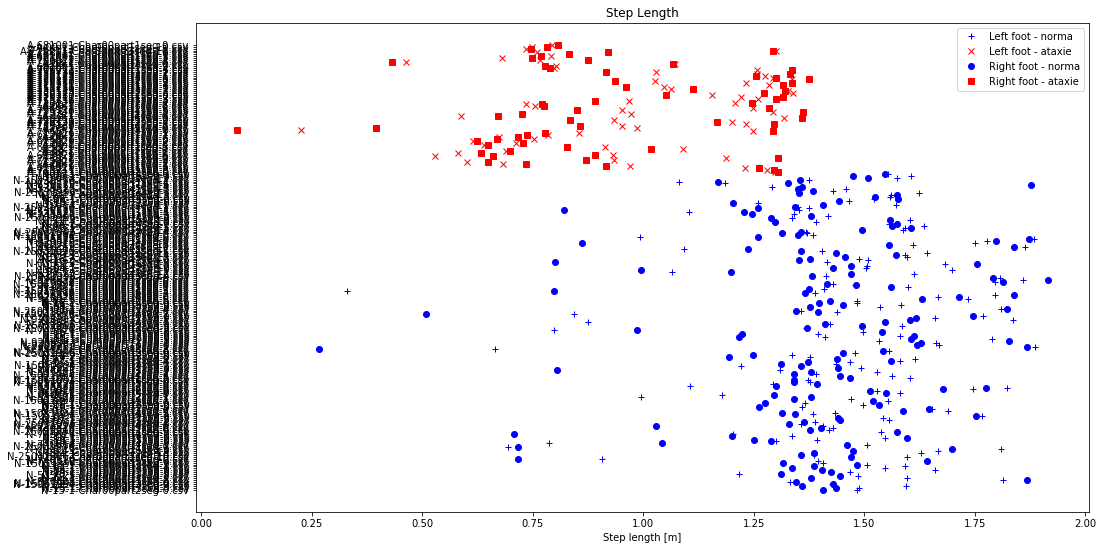

In [14]:
fig = plt.figure(figsize=(16,9))
plt.plot(A.loc[A.Type=='N','StepLenL'],A.loc[A.Type=='N','File'],'b+')
plt.plot(A.loc[A.Type=='A','StepLenL'],A.loc[A.Type=='A','File'],'rx')
plt.plot(A.loc[A.Type=='N','StepLenR'],A.loc[A.Type=='N','File'],'bo')
plt.plot(A.loc[A.Type=='A','StepLenR'],A.loc[A.Type=='A','File'],'rs')
plt.title('Step Length')
plt.legend(['Left foot - norma','Left foot - ataxie','Right foot - norma','Right foot - ataxie'])
plt.xlabel('Step length [m]')

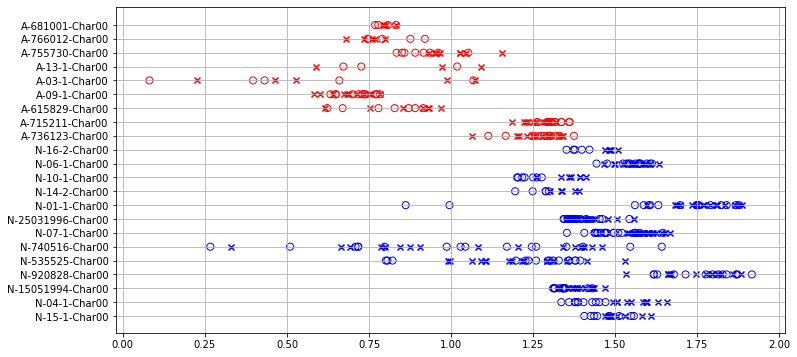

In [15]:
plt.figure(figsize=(12,6))
sub=A.loc[A['Type'] == 'N']
plt.scatter(x=sub.StepLenL,y=sub.Subject,c='b',marker='x')
plt.scatter(x=sub.StepLenR,y=sub.Subject,facecolors='none',s=50,edgecolors='b')
sub=A.loc[A['Type'] == 'A']
plt.scatter(x=sub.StepLenL,y=sub.Subject,c='r',marker='x')
plt.scatter(x=sub.StepLenR,y=sub.Subject,facecolors='none',s=50,edgecolors='r')
plt.grid()

In [16]:
A.loc[A.StepLenR < 0.5,'File']

93       A-03-1-Char00part4seg-0.csv
94       A-03-1-Char00part5seg-0.csv
97     N-740516-Char00part6seg-3.csv
199      A-03-1-Char00part2seg-0.csv
Name: File, dtype: object

In [17]:
A.loc[A.StepLenR > 1.6,'File']

6       N-920828-Char00part1seg-0.csv
16      N-740516-Char00part5seg-0.csv
22        N-01-1-Char00part1seg-0.csv
47        N-01-1-Char00part2seg-8.csv
55        N-07-1-Char00part1seg-2.csv
67      N-920828-Char00part7seg-0.csv
68      N-920828-Char00part6seg-0.csv
98        N-01-1-Char00part2seg-2.csv
101    N-920828-Char00part10seg-0.csv
102    N-920828-Char00part11seg-0.csv
103    N-920828-Char00part11seg-1.csv
106       N-01-1-Char00part2seg-3.csv
108       N-06-1-Char00part3seg-0.csv
120       N-01-1-Char00part2seg-1.csv
124    N-920828-Char00part11seg-2.csv
128       N-01-1-Char00part2seg-0.csv
134       N-01-1-Char00part2seg-4.csv
144       N-01-1-Char00part2seg-5.csv
145     N-920828-Char00part9seg-0.csv
146     N-920828-Char00part8seg-0.csv
160     N-920828-Char00part3seg-0.csv
161     N-920828-Char00part2seg-0.csv
163       N-01-1-Char00part2seg-6.csv
171      N-01-1-Char00part2seg-10.csv
181      N-01-1-Char00part2seg-12.csv
184     N-920828-Char00part4seg-0.csv
185     N-92

### XY LENGTH OF STEPS ( euclidean distance of first and last frame in X and Y axis)

Text(0.5, 0, 'XY length [m]')

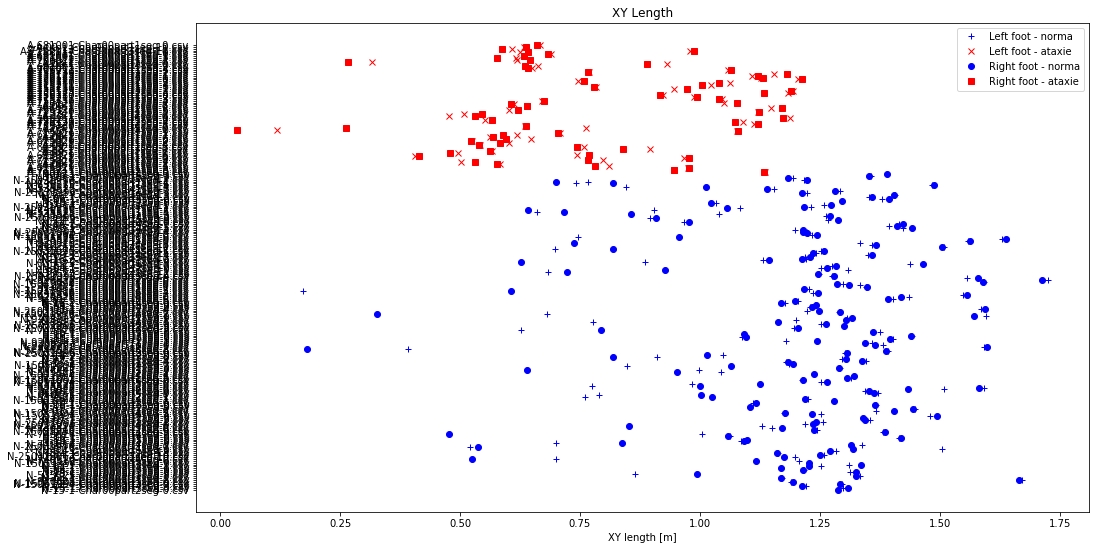

In [18]:
fig = plt.figure(figsize=(16,9))
plt.plot(A.loc[A.Type=='N','XY_LenL'],A.loc[A.Type=='N','File'],'b+')
plt.plot(A.loc[A.Type=='A','XY_LenL'],A.loc[A.Type=='A','File'],'rx')
plt.plot(A.loc[A.Type=='N','XY_LenR'],A.loc[A.Type=='N','File'],'bo')
plt.plot(A.loc[A.Type=='A','XY_LenR'],A.loc[A.Type=='A','File'],'rs')
plt.title('XY Length')
plt.legend(['Left foot - norma','Left foot - ataxie','Right foot - norma','Right foot - ataxie'])
plt.xlabel('XY length [m]')

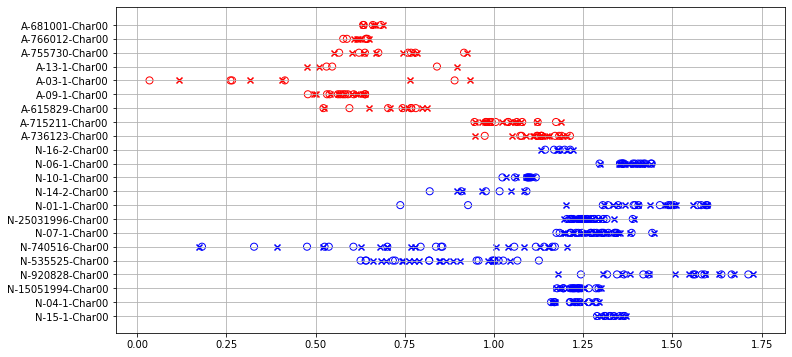

In [19]:
plt.figure(figsize=(12,6))
sub=A.loc[A['Type'] == 'N']
plt.scatter(x=sub.XY_LenL,y=sub.Subject,c='b',marker='x')
plt.scatter(x=sub.XY_LenR,y=sub.Subject,facecolors='none',s=50,edgecolors='b')
sub=A.loc[A['Type'] == 'A']
plt.scatter(x=sub.XY_LenL,y=sub.Subject,c='r',marker='x')
plt.scatter(x=sub.XY_LenR,y=sub.Subject,facecolors='none',s=50,edgecolors='r')
plt.grid()

### STANDARD DEVIATION OF COM
(COM = Center of Mass) - average joint from ['Spine3','Spine2','Spine1','Spine','Hips']

Text(0.5, 0, 'SD [m]')

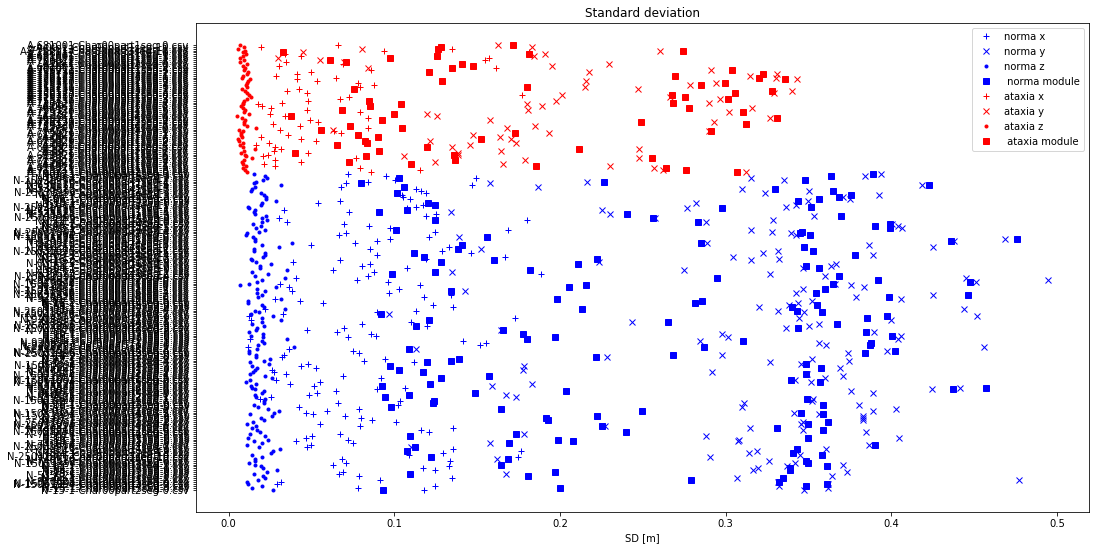

In [20]:
fig = plt.figure(figsize=(16,9))
plt.plot(A.loc[A.Type=='N','sd_x'],A.loc[A.Type=='N','File'],'b+')
plt.plot(A.loc[A.Type=='N','sd_y'],A.loc[A.Type=='N','File'],'bx')
plt.plot(A.loc[A.Type=='N','sd_z'],A.loc[A.Type=='N','File'],'b.')
plt.plot(A.loc[A.Type=='N','sd'],A.loc[A.Type=='N','File'],'bs')
plt.plot(A.loc[A.Type=='A','sd_x'],A.loc[A.Type=='A','File'],'r+')
plt.plot(A.loc[A.Type=='A','sd_y'],A.loc[A.Type=='A','File'],'rx')
plt.plot(A.loc[A.Type=='A','sd_z'],A.loc[A.Type=='A','File'],'r.')
plt.plot(A.loc[A.Type=='A','sd'],A.loc[A.Type=='A','File'],'rs')
plt.title('Standard deviation')
plt.legend(['norma x','norma y','norma z',' norma module','ataxia x','ataxia y','ataxia z',' ataxia module'])
plt.xlabel('SD [m]')

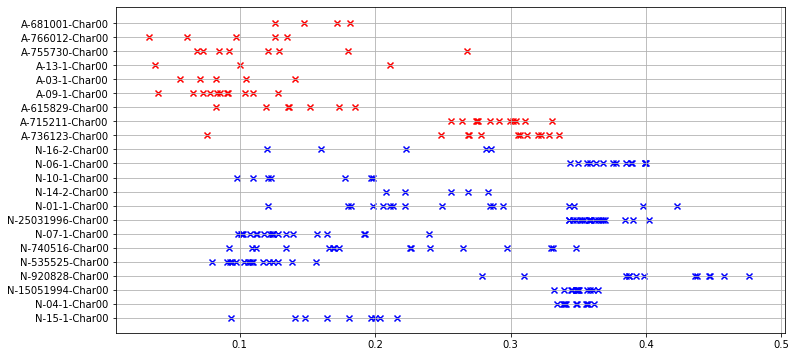

In [21]:
plt.figure(figsize=(12,6))
sub=A.loc[A['Type'] == 'N']
plt.scatter(x=sub.sd,y=sub.Subject,c='b',marker='x')
sub=A.loc[A['Type'] == 'A']
plt.scatter(x=sub.sd,y=sub.Subject,c='r',marker='x')
plt.grid()

In [22]:
A.to_csv('../data/FEATURES.csv',index=False)